In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

folders = {
    "Abnormal Heartbeat": r"D:\FYP\Cadivas CNN\preprocessed_1d\AHB",
    "Myocardial Infarction": r"D:\FYP\Cadivas CNN\preprocessed_1d\MI",
    "Normal": r"D:\FYP\Cadivas CNN\preprocessed_1d\NORMAL",
    "History of MI": r"D:\FYP\Cadivas CNN\preprocessed_1d\PM"
}

In [2]:
all_data = []

for label, folder in folders.items():
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder, file))
            df['Class'] = label
            all_data.append(df)

data = pd.concat(all_data, ignore_index=True)

# Features & labels
X = data.iloc[:, :255].values.astype(np.float32)  # ensure float
y = data['Class'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)

# Reshape for 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

num_classes = y_onehot.shape[1]

In [3]:
inputs = Input(shape=(X_train.shape[1], 1))

# CNN Block
x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(256, kernel_size=5, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

# Transformer Block
x_norm = LayerNormalization(epsilon=1e-6)(x)
attn_output = MultiHeadAttention(num_heads=8, key_dim=x.shape[2], dropout=0.2)(x_norm, x_norm)
x = Add()([x, attn_output])
x_norm2 = LayerNormalization(epsilon=1e-6)(x)
ff = Dense(256, activation='relu')(x_norm2)
ff = Dropout(0.2)(ff)
x = Add()([x, ff])
x = GlobalAveragePooling1D()(x)

# Fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 255, 128)     768         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 127, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 127, 256)     164096      ['max_pooling1d[0][0]']          
                                                                                              

In [4]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('Hybrid_CNN_Transformer_best.h5', monitor='val_accuracy', save_best_only=True)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
302/302 [==============================] - 73s 231ms/step - loss: 1.4364 - accuracy: 0.2768 - val_loss: 1.3763 - val_accuracy: 0.3063
Epoch 2/100
302/302 [==============================] - 46s 154ms/step - loss: 1.3772 - accuracy: 0.3055 - val_loss: 1.3788 - val_accuracy: 0.2574
Epoch 3/100
302/302 [==============================] - 47s 157ms/step - loss: 1.3783 - accuracy: 0.3011 - val_loss: 1.3739 - val_accuracy: 0.3063
Epoch 4/100
302/302 [==============================] - 46s 154ms/step - loss: 1.3764 - accuracy: 0.2997 - val_loss: 1.3715 - val_accuracy: 0.3063
Epoch 5/100
302/302 [==============================] - 47s 154ms/step - loss: 1.3731 - accuracy: 0.3060 - val_loss: 1.3712 - val_accuracy: 0.3063
Epoch 6/100
302/302 [==============================] - 44s 147ms/step - loss: 1.3747 - accuracy: 0.3025 - val_loss: 1.3714 - val_accuracy: 0.3063
Epoch 7/100
302/302 [==============================] - 45s 148ms/step - loss: 1.3732 - accuracy: 0.3069 - val_loss: 1.3718 -

76/76 [==============================] - 4s 50ms/step


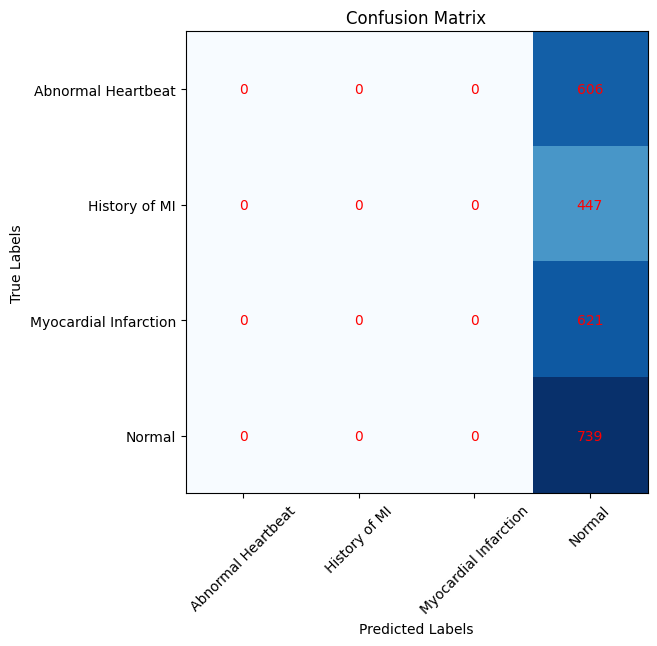

                       precision    recall  f1-score   support

   Abnormal Heartbeat       0.00      0.00      0.00       606
        History of MI       0.00      0.00      0.00       447
Myocardial Infarction       0.00      0.00      0.00       621
               Normal       0.31      1.00      0.47       739

             accuracy                           0.31      2413
            macro avg       0.08      0.25      0.12      2413
         weighted avg       0.09      0.31      0.14      2413



C:\Users\prabh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prabh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prabh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [5]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.xticks(range(num_classes), label_encoder.classes_, rotation=45)
plt.yticks(range(num_classes), label_encoder.classes_)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))